## Load libraries, parameters and data

In [1]:
!sudo pip install torchvision -q 
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
param = {'batch_size' : 64,
        'test_batch_size' : 1000,
        'lr' : 0.0005,
        'momentum' : 0.5,
        'log_interval' : 1}

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=param['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=param['test_batch_size'], shuffle=True)

torch.Size([28, 28])


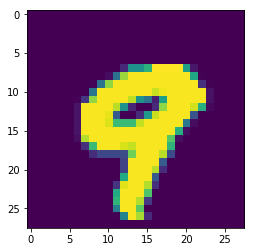

In [4]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    batch_idx
    break

print(data[0,0].shape)
plt.imshow(data[0,0].cpu().numpy())


## Models

In [5]:
to_variable = lambda x: Variable(x.cuda())

In [6]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*4*4+10, 512)
        self.fc2 = nn.Linear(512, 1)
        
        # Conditional
        self.digit_emb = nn.Embedding(10,10)

    def forward(self, x, target):
        x = x.view(-1,1,28,28)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        #x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        cond_emb = self.digit_emb(target)
        x = torch.cat((x, cond_emb), dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
d = DQN()
d.cuda()

DQN (
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (522 -> 512)
  (fc2): Linear (512 -> 1)
  (digit_emb): Embedding(10, 10)
)

In [7]:
class Generator(nn.Module):
    def __init__(self,noise_dim=100, out_dim = 28*28):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(noise_dim + 10,8*8)
        self.conv1 = nn.Conv2d(1,128,6, padding = 2)
        self.conv2 = nn.Conv2d(128,64,3, padding = 2)
        self.conv3 = nn.Conv2d(64,16,3, padding = 0)
        self.conv4 = nn.Conv2d(16,1,3, padding = 0)
        self.up2 = nn.UpsamplingNearest2d(scale_factor=2)
        
        # Conditional
        self.digit_emb = nn.Embedding(10, 10)
    def forward(self,x, target):
        cond_vec = torch.cat((x, self.digit_emb(target)), 1)
        out = F.tanh(self.fc1(cond_vec))
        out = out.view(-1,1,8,8)
        out = self.conv1(out)
        out = F.relu(out)
        out = self.up2(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.up2(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = F.tanh(out)        

        out = out.view(-1,28,28)
        return out
    
g = Generator()
g.cuda()


Generator (
  (fc1): Linear (110 -> 64)
  (conv1): Conv2d(1, 128, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
  (up2): UpsamplingNearest2d(scale_factor=2, mode=nearest)
  (digit_emb): Embedding(10, 10)
)

In [8]:
z = to_variable(torch.randn(5,100))
targets = to_variable(torch.floor(torch.rand(5)*10).type(torch.LongTensor))
print(z.data.shape)
print(g(z, targets).data.shape)

torch.Size([5, 100])
torch.Size([5, 28, 28])


/usr/local/lib/python2.7/dist-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


In [9]:
x = Variable(data[:5,0])
#print(x.data.shape)
yhat = d(x, targets)
yhat.data.shape

torch.Size([5, 1])

## Train

In [10]:
opt_d = optim.Adam(d.parameters(), lr=param['lr'])
opt_g = optim.Adam(g.parameters(), lr=param['lr'])

In [11]:
### Train discriminator
def train_epoch():
    for i, [images,label] in enumerate(train_loader):
        z = to_variable(torch.randn(param['batch_size'],100))
        noise_targets = to_variable(torch.floor(torch.rand(param['batch_size'])*10).type(torch.LongTensor))
        x = to_variable(images)
        real_targets = to_variable(label)

        # Real images
        pred_real = d(x, real_targets)
        real_loss = torch.mean((pred_real-1)**2)

        # Fake images
        pred_fake = d(g(z, noise_targets), noise_targets)
        fake_loss = torch.mean((pred_fake)**2)

        d_loss = fake_loss + real_loss
        opt_d.zero_grad()
        d_loss.backward()
        opt_d.step()

        ### Train generator
        z = to_variable(torch.randn(param['batch_size'],100))
        noise_targets = to_variable(torch.floor(torch.rand(param['batch_size'])*10).type(torch.LongTensor))
        fake_img = g(z, noise_targets)
        pred_fake = d(fake_img, noise_targets)
        g_loss = torch.mean( (pred_fake - 1)**2)

        opt_g.zero_grad()
        g_loss.backward()
        opt_g.step()

In [13]:
fixed_noise = to_variable(torch.randn(10, 100))
fixed_noise_targets = to_variable(torch.from_numpy(np.array(range(10))))
#fixed_noise_targets

epoch 0:


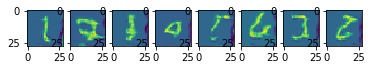

epoch 4:


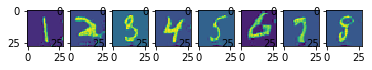

epoch 8:


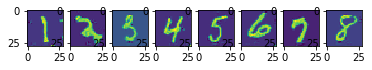

epoch 12:


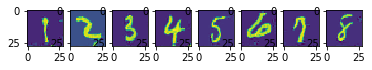

epoch 16:


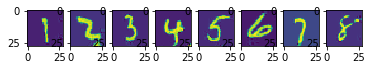

epoch 20:


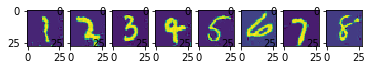

epoch 24:


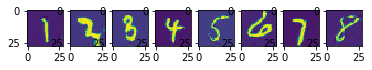

epoch 28:


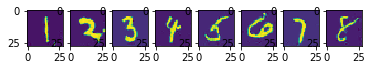

epoch 32:


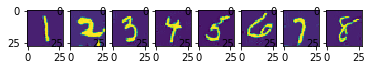

KeyboardInterrupt: 

In [14]:
def plot_images(fake_img):
    for i in range(1,9):
        plt.subplot(1,8,i)
        plt.imshow(fake_img[i,])
    plt.show()

for epoch in range(50):
    train_epoch()
    
    if epoch % 4 == 0:
        print("epoch %s:" % epoch)
        fake_img = g(fixed_noise, fixed_noise_targets).data.cpu().numpy()
        plot_images(fake_img)

epoch 0:


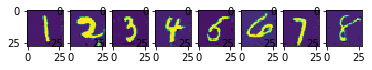

epoch 4:


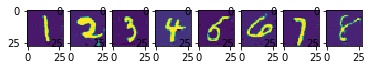

epoch 8:


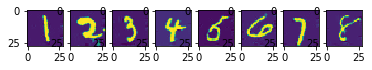

epoch 12:


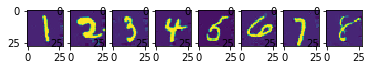

KeyboardInterrupt: 

In [15]:
param['lr'] = 0.00005
opt_d = optim.Adam(d.parameters(), lr=param['lr'])
opt_g = optim.Adam(g.parameters(), lr=param['lr'])

for epoch in range(100):
    train_epoch()
    
    if epoch % 4 == 0:
        print("epoch %s:" % epoch)
        fake_img = g(fixed_noise, fixed_noise_targets).data.cpu().numpy()
        plot_images(fake_img)

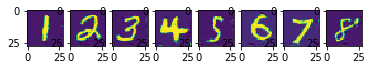

In [18]:
fixed_noise = to_variable(torch.randn(10, 100))
fixed_noise_targets = to_variable(torch.from_numpy(np.array(range(10))))
fake_img = g(fixed_noise, fixed_noise_targets).data.cpu().numpy()
plot_images(fake_img)